In [1]:
### Coding exercise for Wang Lab
# Implementation of nnU-net for the segmentation of pancreas and pancreatic lesions on CT scan, with classication of the pancreatic lesions
# by Leo Chen
# August/September 2024

In [2]:
### IMPORTS
import os
#import util

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.init as init

from collections import defaultdict
from collections import Counter

from datetime import datetime

import SimpleITK as sitk
#import nibabel as nib

In [3]:
### GLOBAL VARIABLES

# GPU?
gpu = True

# first time running? need to generate csv and npy files
firstrun = True

# directories where the files arez
traindir = '/kaggle/input/pancreas/train/'
valdir = '/kaggle/input/pancreas/validation/'
testdir = '/kaggle/input/pancreas/test'

numpydir = '/kaggle/working/numpy'

modeldir = '/kaggle/working/models'

csvpath = '/kaggle/working/trainval_metadata.csv'   # csv with the image dimensions, image and mask file paths

resampleddir = '/kaggle/working/resampled'

if os.path.exists(modeldir) == False:
    os.makedirs(modeldir)


model_depth = 4

# patch size
# change to 92? padding?
patch_width = 64
patch_height = 64

In [4]:
### FUNCTIONS FOR IMAGE AUGMENTATION

def rotateImage(original, anglex, angley, anglez, interpolate='linear'):
    """ Returns the 'rotated' 3d image about the physical center that is resampled based on the 'original' image
    1. original - original image 
    2. angle x is roll / twisting the body like a rolling pin, turning in dance
    3. angle y is yaw / rotating the body like a propeller blade, like break dancing
    4. angle z - pitch / tilt along the superior/inferior axis (i.e trendelenburg)
    
    """

    if interpolate == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolate == 'NN':
        interpolator = sitk.sitkNearestNeighbor

    radx = anglex * math.pi / 180
    rady = angley * math.pi / 180
    radz = anglez * math.pi / 180

    origin = np.array(original.GetOrigin())
    pixelcenter = np.array(sitk.GetSize(original)) / 2.
    physicalcenter = sitk.TransformContinuousIndexToPhysicalPoint(pixelcenter)

    transform = sitk.Euler3DTransform()
    transform.SetCenter(physicalcenter)
    transform.SetRotation(radz, rady, radx)    # note the order is z, y, x

    unitvecs = np.transpose(np.reshape(original.GetDirection(), (-1, 3)))
    #print(unitvecs)
    matrix = np.reshape(transform.GetMatrix(), (-1, 3))
    inverse = np.linalg.inv(matrix)


    # the transform matrix is actually mapping backwards: post to pre
    # therefore the forward transformation is the inverse matrix
    transformedunitvecs = inverse @ unitvecs   # new i, j, k are columns
    #print(transformedunitvecs)
    newdirection = transformedunitvecs.flatten('F')    # flatten by column

    print(newdirection)
    neworigin = (matrix @ (origin - physicalcenter)) + physicalcenter

    rotatedImage = sitk.Resample(original, original, transform, interpolator)
    rotatedImage.SetDirection(newdirection)
    rotatedImage.SetOrigin(neworigin)

    return rotatedImage

def flipImage(original):
    """Flips an SimpleITK over left/right axis"""
    flipped = sitk.Flip(original, [True, False, False])
    return flipped

def flipslice(original):
    """Flips a numpy slice (2d image) """
    # flips 2D slice (reverses x indices)
    flipped = np.flipud(original)  #np.fliplr(original)
    return flipped

def bbox_3D(img):
    """Finds the bounding box around a 3D image (numpy)
    returns rmin, rmax, cmin, cmax, zmin, zmax (r = row, c = column)"""
    try:    
        z = np.any(img, axis=(1, 2))    #z
        c = np.any(img, axis=(0, 2))    #y , (c = column)
        r = np.any(img, axis=(0, 1))    #x , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
        zmin, zmax = np.where(z)[0][[0, -1]]

        #x min max, y min max, z min max
        return [rmin, rmax, cmin, cmax, zmin, zmax]
    except:
        return -1, -1, -1, -1, -1, -1


def bbox_2D(img):
    """Finds the bounding box around a 2D image (numpy)
    returns rmin, rmax, cmin, cmax (r = row, c = column)
    If no elements exist, then returns (-1, -1, -1, -1)"""
    
    try:
        c = np.any(img, axis=0)    #y , (c = column)
        r = np.any(img, axis=1)    #x , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
    
        return rmin, rmax, cmin, cmax
    except:
        return -1, -1, -1, -1


def cropImage(image, threshold, xshift, yshift):
    """Crops SimpleITK image to remove pixels below a threshold (e.g. black space)
    Can also shift by *xshift and *yshift (random shifts in pixels) for augmentation"""
    # load image
    npy = sitk.GetArrayFromImage(image)

    # GET METADATA
    direction = image.GetDirection()
    spacing = image.GetSpacing()

    # CALCULATE BOUNDING BOX OF BODY (removes black space)
    mask = npy > threshold
    [xmin, xmax, ymin, ymax, zmin, zmax] = bbox_3D(mask)

    # check to make sure shifts do not extend outside boundaries of image
    if xmin + xshift < 0 or xmax + xshift > npy.shape[2]:
        xshift = 0

    if ymin + yshift < 0 or ymax + yshift > npy.shape[1]:
        yshift = 0

    # CROP IMAGE
    newnpy = npy[zmin:zmax, (ymin+yshift):(ymax+yshift), (xmin+xshift):(xmax+xshift)]

    newimage = sitk.GetImageFromArray(newnpy)
    topleft = [int(xmin+xshift), int(ymin+yshift), zmin]
    neworigin = image.TransformIndexToPhysicalPoint(topleft)

    newimage.SetOrigin(neworigin)
    newimage.SetDirection(direction)
    newimage.SetSpacing(spacing)

    return newimage


def squareImage(image):
    """Makes an SimpleITK image square by padding with zeros
    (square meaning width = height)"""
    [numcols, numrows, numslices] = image.GetSize()
    npy = sitk.GetArrayFromImage(image)

    if numcols < numrows:    #pad columns
        numzerostopad = numrows - numcols
        leftpad = int(numzerostopad / 2)
        rightpad = numzerostopad - leftpad

        newnpy = np.concatenate((np.zeros([numslices, numrows, leftpad]), npy, np.zeros([numslices, numrows, rightpad])), axis=2)

        topleft = [-leftpad, 0, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    elif numrows <= numcols:  #pad rows
        numzerostopad = numcols - numrows
        toppad = int(numzerostopad / 2)
        botpad = numzerostopad - toppad

        newnpy = np.concatenate((np.zeros([numslices, toppad, numcols]), npy, np.zeros([numslices, botpad, numcols])), axis=1)

        topleft = [0, -toppad, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    paddedimg = sitk.GetImageFromArray(newnpy)
    paddedimg.SetOrigin(neworigin)
    paddedimg.SetDirection(image.GetDirection())
    paddedimg.SetSpacing(image.GetSpacing())

    return paddedimg

def resampleImage(image, finalsize, interpolation='linear'):
    """Resamples SimpleITK image to finalsize x finalsize (width and height in pixels)
    Preserves the original physical size of the image and number of slices
    Changes the resolution so that the new image has numslices x *finalsize x *finalsize dimensions"""
    
    size = image.GetSize()
    numslices = size[2]
    squaresize = size[1]

    # RESAMPLE TO finalsize x finalsize
    finalnpy = np.zeros([numslices, finalsize, finalsize])
    reference = sitk.GetImageFromArray(finalnpy)
    reference.SetOrigin(image.GetOrigin())
    reference.SetDirection(image.GetDirection())

    spacing = image.GetSpacing()
    newspacing = np.zeros(3)
    newspacing[0:2] = (squaresize - 1) * np.array(spacing[0:2]) / (finalsize - 1)
    newspacing[2] = spacing[2]
    reference.SetSpacing(newspacing)


    # MAKING RESAMPLING FILTER
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolation == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolation == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    # RESAMPLE TO finalsize x finalsize x n
    resampledimg = resample.Execute(image)

    return resampledimg


def projectImage(reference, moving, interpolate = 'linear'):
    """Projects an SimpleITK image (*moving onto *reference)
    interpolate* = linear or NN (nearest neighbor)"""
    
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolate == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolate == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    resampledimg = resample.Execute(moving)

    return resampledimg

In [5]:
### U-Net model classes and functions


class UNet(nn.Module):
    """2D U-Net Model (barebones nn-Unet architecture without hyperparameter optimization)

    Based on the paper:
    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    by Olaf Ronneberger, Philipp Fischer, Thomas Brox
    (https://arxiv.org/abs/1505.04597)
    
    Adapated code from Andrew Ng's lab
    """

    def __init__(self, model_depth=5, num_channels=1, num_classes=1, init_method=None, **kwargs):
        super(UNet, self).__init__()
        self.depth = model_depth
        self.num_channels = num_channels
        self.num_classes = num_classes

        u_channels = 64  # Number of channels at the top of the "U"
        layer_depths = [i for i in range(1, model_depth)]

        self.input_conv = UNetConvBlock(self.num_channels, u_channels)

        self.encoders = nn.ModuleList([UNetEncoder(u_channels * 2**(i - 1), u_channels * 2**i)
                                       for i in layer_depths])

        self.decoders = nn.ModuleList([UNetDecoder(u_channels * 2**i, u_channels * 2**(i - 1))
                                       for i in reversed(layer_depths)])

        self.output_conv = nn.Conv2d(u_channels, self.num_classes, 1)

        # nn.Conv2d 
        # input is tensor  (N, Cin, Hin,  Win)
        # output is tensor (N, Cout,Hout, Wout)
        # N is a batch size, C denotes a number of channels, H is a height of input planes in pixels, and W is width in pixels
        
        
        if init_method is not None:
            self._initialize_weights(init_method)

    def _initialize_weights(self, init_method):
        """Initialize all weights in the network."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if init_method == 'normal':
                    init.normal_(m.weight, 0.0, 0.2)
                elif init_method == 'xavier':
                    init.xavier_normal_(m.weight, 0.2)
                elif init_method == 'kaiming':
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                else:
                    raise NotImplementedError('Invalid initialization method: {}'.format(self.init_method))
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or (isinstance(m, nn.GroupNorm) and m.affine):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_conv(x)
        skips = []

        # Encode and save skip connections
        for encoder in self.encoders:
            skips.append(x)
            x = encoder(x)

        # Decode with skip connections
        for decoder in self.decoders:
            x_skip = skips.pop()
            x = decoder(x, x_skip)

        # Generate mask
        x = self.output_conv(x)

        return x

    def args_dict(self):
        """Get a dictionary of args that can be used to reconstruct this architecture.
        To use the returned dict, initialize the model with `LRCN(**model_args)`.
        """
        model_args = {'model_depth': self.depth,
                      'num_channels': self.num_channels,
                      'num_classes': self.num_classes}

        return model_args

    
class UNetConvBlock(nn.Module):
    """2 x (Conv2d, BatchNorm2d, ReLU)"""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bias=True):
        super(UNetConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=use_bias)
        self.norm1 = nn.GroupNorm(out_channels // 16, out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=use_bias)
        self.norm2 = nn.GroupNorm(out_channels // 16, out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)

        return x
    
    
class UNetCopyCrop(nn.Module):
    """Layer for cropping then concatenating skip connection in UNet."""
    def __init__(self):
        super(UNetCopyCrop, self).__init__()

    def forward(self, x, x_skip):
        crop_h = (x.size(2) - x_skip.size(2))
        crop_w = (x.size(3) - x_skip.size(3))
        # Round in opposite directions on either side
        x_skip = F.pad(x_skip, (crop_h//2, int(crop_h/2), crop_w//2, int(crop_w/2)))
        x = torch.cat([x_skip, x], dim=1)

        return x

    
class UNetDecoder(nn.Module):
    """Decoder (up-sampling layer) for UNet"""
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.copy_crop = UNetCopyCrop()
        self.conv = UNetConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, x_skip):
        x = self.up(x)
        x = torch.cat([x_skip, x], dim=1)  # self.copy_crop(x, x_skip)
        x = self.conv(x)

        return x
    

class UNetEncoder(nn.Module):
    """Encoder (down-sampling layer) for UNet"""
    def __init__(self, in_channels, out_channels):
        super(UNetEncoder, self).__init__()
        self.pool = nn.Conv2d(in_channels, in_channels, 2, stride=2)
        self.conv = UNetConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)

        return x

In [6]:
### FUNCTIONS FOR READING/LOADING THE DATA

# returns a list of file paths, sorted alphabetically
def getImageAndMaskFilePaths(train_or_val, subtype):
    # input: training or validation images ('train' or 'val', and the subtype {0, 1, or 2}
    
    if train_or_val == 'train':
        rootdir = traindir        
    elif train_or_val == 'val':
        rootdir = valdir
        
    subtypedir = os.path.join(rootdir, 'subtype' + str(subtype))
    
    
    ## this gets all of the file paths in the subtype folder for the image and mask files
    
    # example file path for a training image of subtype 0:
    #   '/kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii'
        
    image_niftis_gz = [os.path.join(subtypedir, file_name) for file_name in os.listdir(subtypedir) if '0000' in file_name]
    image_niftis_gz.sort()
    
    mask_niftis_gz = [file_name.partition("_0000")[0] + '.nii' for file_name in image_niftis_gz]
    
    
    
    ## however the actual CT / segmentation is within the zipped files:
    #   '/kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii/PANORAMA_101960_00001_0000.nii'
    
    # this gets the actual PANORAMA file:
    image_niftis_panorama= [os.path.join(image, os.listdir(image)[0]) for image in image_niftis_gz]
    mask_niftis_panorama = [os.path.join(mask, os.listdir(mask)[0]) for mask in mask_niftis_gz]
    
    return [image_niftis_panorama, mask_niftis_panorama]
   
    
    
# Creates a dataframe with the following:
# study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
  #   // CT spacing x/y/z 
def getImageFileDetails(imageniftis, maskniftis, train_or_val):
    # Input is a list of image nifti file paths, mask nifti file paths (panorama), and {'train' or 'val'}
    
    maindf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),        
                   'image path': pd.Series(dtype='string'),
                   'mask path': pd.Series(dtype='string')
                  })

    for i, imagepath in enumerate(imageniftis):
        #print(i)
        maskpath = maskniftis[i]
    
        #print(maskpath)
        
        ## gets the subtype, ID for the current image
        # (format of the file name is: /kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii/PANORAMA_101960_00001_0000.nii)
        subfolder = [folder for folder in imagepath.split('/') if 'quiz' in folder][0]   #gets the subdirectory with "quiz"
        
        subtype = subfolder.split('_')[1]
        ID = subfolder.split('_')[2]
        
        
        ## gets the dimensions of CT image in pixels
        img = sitk.ReadImage(imagepath)
        #img_vol = sitk.GetArrayFromImage(img)
        
        CTwidth = img.GetWidth()
        CTheight = img.GetHeight()
        CTdepth = img.GetDepth()
                
        ## gets the dimensions of the pancreas and lesion segmentations
        mask = sitk.ReadImage(maskpath)
        mask_vol = sitk.GetArrayFromImage(mask)
    
        [xmin1, xmax1, ymin1, ymax1, zmin1, zmax1] = bbox_3D(np.int64(mask_vol) == 1)   # 1 = pancreas
        [xmin2, xmax2, ymin2, ymax2, zmin2, zmax2] = bbox_3D(np.int64(mask_vol) == 2)   # 2 = lesion
 
        width1 = xmax1 - xmin1
        height1 = ymax1 - ymin1
        depth1 = zmax1 - zmin1
        
        width2 = xmax2 - xmin2
        height2 = ymax2 - ymin2
        depth2 = zmax2 - zmin2

        ## gets the spacing (mm) and 'direction' vectors of x/y/z axis
        spacing = img.GetSpacing()
        direction = img.GetDirection()
        directionx = str(direction[0:2])
        directiony = str(direction[3:5])
        directionz = str(direction[6:8])
        
        # study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
          #   // CT spacing x/y/z 
        df = pd.DataFrame({'train/val':train_or_val, 'ID':ID, 'subtype':subtype, 'CT width':CTwidth, 'CT height':CTheight, 'CT depth':CTdepth, 
                           'panc width':width1, 'panc height':height1, 'panc depth':depth1, 
                           'lesion width':width2, 'lesion height':height2, 'lesion depth':depth2,
                           'panc xmin':xmin1, 'panc xmax':xmax1, 'panc ymin': ymin1, 'panc ymax':ymax1, 'panc zmin': zmin1, 'panc zmax':zmax1,
                           'CT spacing x':spacing[0], 'CT spacing y':spacing[1], 'CT spacing z':spacing[2], 
                           'CT direction x':directionx, 'CT direction y':directiony, 'CT direction z':directionz, 
                           'image path': imagepath, 'mask path': maskpath}, index = [0])
                           
        
        maindf = pd.concat([maindf, df])
                 
            
    return maindf
        

    
def getResampledImageFileDetails(imagepath, maskpath, ID, subtype, train_or_val):
    # Input is single image nifti file path, mask nifti file path (not panorama), and {'train' or 'val'}
    
    resampleddf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),        
                   'image path': pd.Series(dtype='string'),
                   'mask path': pd.Series(dtype='string')
                  })



    ## gets the dimensions of CT image in pixels
    img = sitk.ReadImage(imagepath)

    CTwidth = img.GetWidth()
    CTheight = img.GetHeight()
    CTdepth = img.GetDepth()

    ## gets the dimensions of the pancreas and lesion segmentations
    mask = sitk.ReadImage(maskpath)
    mask_vol = sitk.GetArrayFromImage(mask)

    [xmin1, xmax1, ymin1, ymax1, zmin1, zmax1] = bbox_3D(np.int64(mask_vol) == 1)   # 1 = pancreas
    [xmin2, xmax2, ymin2, ymax2, zmin2, zmax2] = bbox_3D(np.int64(mask_vol) == 2)   # 2 = lesion

    width1 = xmax1 - xmin1
    height1 = ymax1 - ymin1
    depth1 = zmax1 - zmin1

    width2 = xmax2 - xmin2
    height2 = ymax2 - ymin2
    depth2 = zmax2 - zmin2

    ## gets the spacing (mm) and 'direction' vectors of x/y/z axis
    spacing = img.GetSpacing()
    direction = img.GetDirection()
    directionx = str(direction[0:2])
    directiony = str(direction[3:5])
    directionz = str(direction[6:8])

    # study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
      #   // CT spacing x/y/z 
    df = pd.DataFrame({'train/val':train_or_val, 'ID':ID, 'subtype':subtype, 'CT width':CTwidth, 'CT height':CTheight, 'CT depth':CTdepth, 
                       'panc width':width1, 'panc height':height1, 'panc depth':depth1, 
                       'lesion width':width2, 'lesion height':height2, 'lesion depth':depth2,
                       'panc xmin':xmin1, 'panc xmax':xmax1, 'panc ymin': ymin1, 'panc ymax':ymax1, 'panc zmin': zmin1, 'panc zmax':zmax1,
                       'CT spacing x':spacing[0], 'CT spacing y':spacing[1], 'CT spacing z':spacing[2], 
                       'CT direction x':directionx, 'CT direction y':directiony, 'CT direction z':directionz, 
                       'image path': imagepath, 'mask path': maskpath}, index = [0])

            
    return df
        

In [7]:
# this loop runs through all of the training and validation images, and builds a dataframe with the metadata


if firstrun:
    maindf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),  
                   'image path': pd.Series(dtype='str'),
                   'mask path': pd.Series(dtype='str')
                  })

    for train_or_val in ['train', 'val']:
        for subtype in range(3):
            images, masks = getImageAndMaskFilePaths(train_or_val, subtype)
        
            subtypedf = getImageFileDetails(images, masks, train_or_val)

            maindf = pd.concat([maindf, subtypedf])
        

# saving the metadata to csv file

    csvpath = '/kaggle/working/trainval_metadata.csv'
    maindf.to_csv(csvpath, index = False)

print('done')

done


In [8]:
def resampleImageToVoxelSize(image, voxelx, voxely, voxelz, interpolation='linear'):
    """Resamples SimpleITK *image* to spacing *[voxelx, voxely, voxelz] in mm
    Preserves the original physical size of the image
    *voxelz is slice thickness (usually)
    *voxelx and *voxely are voxel width and height, respectively
    """
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_spacing = [voxelx, voxely, voxelz]
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    # new dimension will be original size * original spacing / new spacing
    # based on physical distance formula: 
    #    original size (pixel) * original spacing (mm / pixel) = new size (pixel) * new spacing (mm / pixel)
    
    if interpolation == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolation == 'NN':
        interpolator = sitk.sitkNearestNeighbor
    
    # creates new image
    new_image = sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())
    
    return new_image


In [9]:
imagepath = '/kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii/PANORAMA_101960_00001_0000.nii'
maskpath = '/kaggle/input/pancreas/train/subtype0/quiz_0_041.nii/PANORAMA_101960_00001.nii'

image = sitk.ReadImage(imagepath)

resampledimg = resampleImageToVoxelSize(image, 1, 1, 3)

In [10]:
print(resampledimg.GetSize())
print(resampledimg.GetSpacing())

(114, 82, 28)
(1.0, 1.0, 3.0)


In [11]:
### Pre-processing the data 
# Resamples the dataset to uniform voxel spacing 1 x 1 x 3 mm (3 mm is the thickness)


# Create the output directories
if os.path.exists(resampleddir) == False:
    os.makedirs(resampleddir)

resampledtrainvaldir = [os.path.join(resampleddir, 'train'), os.path.join(resampleddir, 'validation')]

for trainvaldir in resampledtrainvaldir:
    if os.path.exists(trainvaldir) == False:
            os.makedirs(trainvaldir)
        
    for subtype in range(3):
        subtypefolder = 'subtype' + str(subtype)
        
        if os.path.exists(os.path.join(trainvaldir, subtypefolder)) == False:
            os.makedirs(os.path.join(trainvaldir, subtypefolder))
    

resampleddf = pd.DataFrame({'ID': pd.Series(dtype='int'),
               'train/val': pd.Series(dtype='string'),
               'subtype': pd.Series(dtype='int'),
               'CT width': pd.Series(dtype='int'),
               'CT height': pd.Series(dtype='int'),
               'CT depth': pd.Series(dtype='int'),
               'panc width': pd.Series(dtype='int'),
               'panc height': pd.Series(dtype='int'),
               'panc depth': pd.Series(dtype='int'),
               'lesion width': pd.Series(dtype='int'),
               'lesion height': pd.Series(dtype='int'),
               'lesion depth': pd.Series(dtype='int'),
               'panc xmin': pd.Series(dtype='int'),
               'panc xmax': pd.Series(dtype='int'),
               'panc ymin': pd.Series(dtype='int'),
               'panc ymax': pd.Series(dtype='int'),
               'panc zmin': pd.Series(dtype='int'),
               'panc zmax': pd.Series(dtype='int'),
               'CT spacing x': pd.Series(dtype='float'),
               'CT spacing y': pd.Series(dtype='float'),
               'CT spacing z': pd.Series(dtype='float'),
               'CT direction x': pd.Series(dtype='float'),
               'CT direction y': pd.Series(dtype='float'),
               'CT direction z': pd.Series(dtype='float'),  
               'image path': pd.Series(dtype='str'),
               'mask path': pd.Series(dtype='str')
              })

for i, row in maindf.iterrows():
    ID = row['ID']
    trainorval = row['train/val']
    imagepath = row['image path']
    maskpath = row['mask path']
    subtype = row['subtype']
    
    #print('ID: ' + str(ID) + 'subtype: ' + str(subtype))
    
    if trainorval == 'val':
        trainorvalidation = 'validation'
    else:
        trainorvalidation = 'train'
        
    rootpath = os.path.join(os.path.join(resampleddir, trainorvalidation), 'subtype' + str(subtype))
    
    newimagefile = imagepath.split('/')[-2]
    newmaskfile = maskpath.split('/')[-2]
    
    newimagepath = os.path.join(rootpath, newimagefile)
    newmaskpath = os.path.join(rootpath, newmaskfile)
    
    
    image = sitk.ReadImage(imagepath)
    mask = sitk.ReadImage(maskpath)
    
    resampledImage = resampleImageToVoxelSize(image, 1, 1, 3)
    resampledMask = projectImage(resampledImage, mask, interpolate = 'NN')
    
    sitk.WriteImage(resampledImage, newimagepath, useCompression=True)
    sitk.WriteImage(resampledMask, newmaskpath, useCompression=True)
    
    
    # builds CSV file
    resampledrowdf = getResampledImageFileDetails(newimagepath, newmaskpath, ID, subtype, trainorval)
    
    resampleddf = pd.concat([resampleddf, resampledrowdf])
    
      
# saving the metadata to csv file
resampledcsvpath = '/kaggle/working/trainval_resampled_metadata.csv'
resampleddf.to_csv(resampledcsvpath, index = False)

print('done resampling data')

done resampling data


In [12]:

resampleddf.to_csv(resampledcsvpath, index = False)

In [12]:
### Pre-processing the data 

# 1. Open the image and segmentation masks (projected onto the image) nifti files
# (currently without data augmentation)

if not os.path.isdir(numpydir):
    os.makedirs(numpydir)   
    

def getNumpysFromImageAndMask(imagepath, maskpath, resample=False):
    """Input is file path of image and mask nifti files (panorama)
       Output is 1. image_npy: a 3D numpy of the CT scan
             2. mask_npy: 3D numpy of the mask, projected onto the image (nearest neighbor)
             """

    image = sitk.ReadImage(imagepath)
    mask = sitk.ReadImage(maskpath)
    
    #image = squareImage(image)
    if resample:
        image = resampleImageToVoxelSize(image, 1, 1, 3)
    
    projected_mask = projectImage(image, mask, interpolate = 'NN')

    image_npy = sitk.GetArrayFromImage(image)   #images are in z, y, x format
    mask_npy = sitk.GetArrayFromImage(mask)
        
    return image_npy, mask_npy


### def augment(***)
                # 1. rotate 3D image
                #anglex = random.randint(0, 23) * 15  # rotate randomly, 15 degree increments from 0 to 345 degrees
                #angley = anglez = 0    #just rolling pin rotation

                #img = rotateImage(original, anglex, angley, anglez, 'linear')
                #seg = rotateImage(original, anglex, angley, anglez, 'nn')
                
                 # 3. make square and resample to 256 x 256***
                #img = squareImage(img)
                #img = resampleImage(img, 256)

                # 4. resample mask to final image
                #seg = projectImage(img, seg, interpolate='NN')
                
                # calculate bounding box of segmentation
                #segbbox = bbox_3D(seg)       #[xmin, xmax, ymin, ymax, zmin, zmax]
                #imgbbox = bbox_3D(img)

                
                
def niftis_to_numpys(df, trainorval, numpydir, resample=False):

    #add has_pancreas
    #add has_lesion
    
    master_slicedf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                                   'subtype': pd.Series(dtype='int'),
                                   'slice': pd.Series(dtype = 'int'),
                                   'has pancreas': pd.Series(dtype='int'),
                                   'has lesion': pd.Series(dtype='int'),
                                   'image npy': pd.Series(dtype = 'string'),
                                   'mask npy': pd.Series(dtype = 'string'),
                                   'image path': pd.Series(dtype='string'),
                                   'mask path': pd.Series(dtype='string')
                                   })
                                   
    
    
    for index, row in df.iterrows():
        imagepath = row['image path']
        maskpath = row['mask path']
        ID = int(row['ID'])
        subtype = row['subtype']
        
        num_slices = row['CT depth']
        
        # saves npy
        image_npy, mask_npy = getNumpysFromImageAndMask(imagepath, maskpath, resample)

        image_filename =  os.path.join(numpydir, str(trainorval) + '_' + "{:03d}".format(ID) + '_image.npy')
        mask_filename = os.path.join(numpydir, str(trainorval) + '_' + "{:03d}".format(ID) + '_mask.npy')
        
        np.save(image_filename, image_npy)
        np.save(mask_filename, mask_npy)
        
        # generates another csv with all of the slices, with ID, slice, has_pancreas, has_lesion
        slice_array = np.arange(0, num_slices, 1)
        has_pancreas = np.sum(np.reshape(mask_npy, (np.shape(mask_npy)[0], -1)) == 1, axis=1) > 0    # indicates if that slice has pancreas
        has_lesion = np.sum(np.reshape(mask_npy, (np.shape(mask_npy)[0], -1)) == 2, axis=1) > 0      # indicates if that slice has lesion
        
        slicedf = pd.DataFrame({'slice': slice_array})
        slicedf['has pancreas'] = has_pancreas
        slicedf['has lesion'] = has_lesion
        slicedf['ID'] = ID
        slicedf['subtype'] = subtype
        slicedf['image path'] = imagepath
        slicedf['mask path'] = maskpath
        slicedf['image npy'] = image_filename
        slicedf['mask npy'] = mask_filename
    
        master_slicedf = pd.concat([master_slicedf, slicedf])
    
        
        
        
        # Saving each individual slice
        #for CTslice in range(np.shape(image_npy)[0]):
        #    image_filename =  os.path.join(numpydir, str(trainorval) + "{:03d}".format(ID) + '_' + "{:03d}".format(CTslice) + '_image.npy')
        #    mask_filename = os.path.join(numpydir, str(trainorval) + "{:03d}".format(ID) + '_' + "{:03d}".format(CTslice) + '_mask.npy')

        #    np.save(image_filename, image_npy[CTslice, :, :])
        #    np.save(mask_filename, mask_npy[CTslice, :, :])

        #print(image_filename)
        #print(mask_filename)
    
    master_slicedf.index = np.arange(0, len(master_slicedf.index), 1)
    
    return master_slicedf
    


In [19]:
if firstrun:
    traindf = maindf.loc[maindf['train/val'] == 'train']
    valdf = maindf.loc[maindf['train/val'] == 'val']

    print('train')
    train_slicedf = niftis_to_numpys(traindf, 'train', numpydir, resample=True)
    train_slicedf.to_csv('train_slices.csv', index=False)

    print('val')
    val_slicedf = niftis_to_numpys(valdf, 'val', numpydir, resample=True)
    val_slicedf.to_csv('val_slices.csv', index=False)

   
    firstrun = False
    
print('done')

train
val
done


In [10]:
def get_patches(image_npy, mask_npy, patch_width, patch_height, topleft_row = 0, topleft_col = 0, 
                has_pancreas = False, has_lesion = False, random = True):
    """ 
    Returns patches of the 'image_npy' and segmentation 'mask_npy'
    with 'patch_width' (columns) and 'patch_height (rows)
    
    Can specify the top left corner: 'topleft_row' and 'topleft_col'
    
    Can specify if patch has to contain pancreas/lesion or not
    
    Can also return a random patch within the image/segmentation
    """
    
    image_height, image_width = np.shape(image_npy)
    
    assert(patch_width < np.shape(image_npy)[1] and patch_height < np.shape(image_npy)[0])   ## CT image is z (slice index), y (row index), x (column index)
    
    if random:   # random patch, within constraints    
    # if it must contain the pancreas and lesion:
    # then you can only go up to panc min - patch size, and panc max + patch size
    # top left is going to be max(0, (panc min - patch size)) to min(image width, panc max + patch size)
    
        if has_lesion:
            rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 2)
            
            #print('lesion patch')
        
            if rmin == -1 and has_pancreas:
                rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 1)
                #print('has_lesion, but pancreas patch')
            
        elif has_pancreas:
            rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 1)
            #print('pancreas patch')
            
        else:
            rmin, rmax, cmin, cmax = (-1, -1, -1, -1)
            #print('random patch')
            
        
        if rmin != -1:
            patch_rmin = max(0, rmin - patch_height)
            patch_rmax = min(image_height - patch_height, rmax)
            patch_cmin = max(0, cmin - patch_width)
            patch_cmax = min(image_width - patch_width, cmax)
            
            #print('lesion patch success')
            
        else:    # gets a random patch, as there is no pancreas or lesion
            patch_rmin = 0
            patch_rmax = image_height - patch_height
            patch_cmin = 0
            patch_cmax = image_width - patch_width
            #print('lesion patch fail')
    
        topleft_row = np.random.randint(patch_rmin, patch_rmax)
        topleft_col = np.random.randint(patch_cmin, patch_cmax)
        
    
    image_patch = image_npy[topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    mask_patch = mask_npy[topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    
    #print(topleft_row, topleft_col)
    
    return image_patch, mask_patch, topleft_row, topleft_col

# Perform one hot encoding on label
def one_hot_encode(label, label_values = [0, 1, 2]):
    """
    Convert a segmentation image label array to one-hot format by replacing each pixel label with an array of n dimension (n labels)
    
    1. label: The 2D array segmentation image label
    2. label_values (in this case, [0, 1, 2])
        
    Returns the one-hot 3d matrix (n x num_row x num_col)
        
    """
    one_hot = []
    
    for number in label_values:
        layer = np.int32(np.equal(label, number))
        one_hot.append(layer)
    
    one_hot = np.stack(one_hot, axis=0)

    return one_hot
    
# Perform reverse one-hot-encoding on labels / preds
def one_hot_decode(one_hot_label):
    """
    Squashes a 3D one hot matrix into a 2D segmentation mask
    """
    label = np.argmax(one_hot_label, axis = 0)
    
    return label



In [11]:
class Dataset(data.Dataset):
    def __init__(self, slicedf, train=False, augment=False, shuffle=False, has_pancreas=False, has_lesion=False):
        super().__init__()
        
        self.slicedf = slicedf
        
        #self.args = args
        self.train = train
        self.augment = augment
        self.shuffle = shuffle
        self.has_pancreas = has_pancreas
        self.has_lesion = has_lesion
        
        
    def __getitem__(self, index):
        #print(self.slicedf)
        
        row = self.slicedf.iloc[index]
                
        slicenum = row['slice']
        
        image_npy = row['image npy']
        mask_npy = row['mask npy']
        ID = row['ID']

        
        image = np.load(image_npy)
        mask = np.load(mask_npy)
        
        #print('ID: ' + str(ID) + '  slice num: ' + str(slicenum) + ' of image ' + str(np.shape(image)) + ' and mask ' + str(np.shape(mask)))
        
        image_slice = image[slicenum, :, :]
        mask_slice = mask[slicenum, :, :]
        
        
        if self.train:     
            # get a random patch
            image_patch, mask_patch, topleft_row, topleft_col = get_patches(image_slice, mask_slice, patch_width, patch_height, 0, 0,
                                                                            self.has_pancreas, self.has_lesion, random = True)            
        else:
            # need to update this so we can get a patch that's not the corner
            image_patch, mask_patch, topleft_row, topleft_col = get_patches(image_slice, mask_slice, patch_width, patch_height, 0, 0,
                                                                            self.has_pancreas, self.has_lesion, random = True)
        
        image_patch = np.reshape(image_patch, (1, np.shape(image_patch)[0], np.shape(image_patch)[1]))    # reshapes into 1 x row x col matrix for batch norm
        
        mask_patch_onehot = one_hot_encode(mask_patch)
        
        input_tensor = torch.FloatTensor(image_patch)
        label_tensor = torch.FloatTensor(mask_patch_onehot)
                

        return input_tensor, label_tensor, ID, slicenum
    
    def __len__(self):
        return self.slicedf.shape[0]

In [12]:
def train_model(model, loader, gpu=False, optimizer=None):
    """ 
    runs one epoch of training
    returns generalized dice loss
    """
    model.train()
    
    total_loss = 0.
    num_batches = 0
    
    for i, batch in enumerate(loader):
        vol, label, ID, slicenum = batch
        
        if gpu:
            vol = vol.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()           
        
        logit = model.forward(vol)
        
        # also can try including binary cross entropy loss       
        loss = generalized_dice_loss(logit, label) #+ cross_entropy_loss_fx(logit, label)
        
        #print('train batch ' + str(i) + ' loss: ' + str(loss.item()))
        
        total_loss += loss.item()  #loss.item()
        
        loss.backward()
        optimizer.step()
        
        num_batches += 1
        

        del vol, label, logit#, loss
    
    avg_loss = total_loss / num_batches

    return avg_loss


def eval_model(model, loader, gpu=False, optimizer=None):
    """ 
    runs one epoch of validation set 
    returns generalized dice loss 
    """
    model.eval()
    
    total_loss = 0.
    num_batches = 0
    
    for i, batch in enumerate(loader):
        with torch.no_grad():
            vol, label, ID, slicenum = batch
        
            if gpu:
                vol = vol.cuda()
                label = label.cuda()
        
            logit = model.forward(vol)
        
            # also can try including binary cross entropy loss        
            loss = generalized_dice_loss(logit, label) #+ cross_entropy_loss_fx(logit, label)
        
            #print('val batch ' + str(i) + ' loss: ' + str(loss.item()))
        
            total_loss += loss.item()  #loss.item()
        
            num_batches += 1
        
            del vol, label, logit, loss
    
    avg_loss = total_loss / num_batches

    return avg_loss

In [13]:
def generalized_dice_loss(prediction, label):
    """
    Function to calculate the Generalized Dice Loss defined in
        Sudre, C. et. al. (2017) Generalized Dice overlap as a deep learning
        loss function for highly unbalanced segmentations. DLMIA 2017
    Implemented by Leo Chen
    
    1. prediction: logits of each pixel (N x row x col tensor)
    2. label: segmentation ground truth (one-hot encoded N x row x col tensor)
    
    Returns the generalized dice loss based on square weighting of pixels
    """
    batch_size = label.size(0)
    num_classes = label.size(1)
    
    prediction = prediction.view(batch_size, num_classes, -1)
    label = label.view(batch_size, num_classes, -1)
    
    probs = F.softmax(prediction, dim=1)
    
    epsilon = 1e-6
      
    num_pixels = torch.sum(label, dim=2)     # gives a 3 x 1 matrix of the number of pixels per class (0 - background, 1 - pancreas, 2  - lesion)
    
    # calculates the weight of each pixel label based on 1/num_pix^2   -- if there are no pixels of that class, weight = 0
    weight = torch.div(num_pixels, (torch.pow(num_pixels, 3) + epsilon))    # added epsilon for numerical stability
    
    numerator_unweighted = torch.sum((probs * label), dim=2)
    denominator_unweighted = torch.sum((probs + label), dim=2)
    
    numerator_expanded = weight * torch.sum((probs * label), dim=2)
    denominator_expanded =  weight * torch.sum((probs + label), dim=2)
    
    
    numerator = torch.sum(weight * torch.sum((probs * label), dim=2))
    denominator =  torch.sum(weight * torch.sum((probs + label), dim=2))
    
    #print(weight.size())
    #print('weight: ' + str(weight[0]))
    
    #print(numerator_expanded.size())
    #print('numerator unweighted by layer: ' + str(numerator_unweighted[0]))
    #print('denominator unweighted by layer: ' + str(denominator_unweighted[0]))
    #print('numerator by layer: ' + str(numerator_expanded[0]))
    #print('denominator by layer: ' + str(denominator_expanded[0]))
    #print('numerator sum: ' + str(numerator))
    #print('denominator sum: ' + str(denominator))
    
    #print(numerator.size())
    
    generalized_dice_loss = 1 - (2*numerator / denominator)
    
    del batch_size, probs, num_pixels, weight, numerator, denominator, numerator_expanded, denominator_expanded
    
    return generalized_dice_loss

   
    

In [14]:
continue_training = False
last_model_path = ''


In [15]:
train_slicedf = pd.read_csv('/kaggle/working/train_slices.csv')
val_slicedf = pd.read_csv('/kaggle/working/val_slices.csv')

# creates two additional dataframes for training and validation purposes:
# 'train_panc_slicedf' and 'val_panc_slicedf' has slices that contain the pancreas
# 'train_panc_lesion_slicedf' and 'val_...' have slices that contain both pancreas and lesion
train_panc_slicedf = train_slicedf[train_slicedf['has pancreas'] == 1]
train_panc_lesion_slicedf = train_panc_slicedf[train_panc_slicedf['has lesion'] == 1]

val_panc_slicedf = val_slicedf[val_slicedf['has pancreas'] == 1]
val_panc_lesion_slicedf = val_panc_slicedf[val_panc_slicedf['has lesion'] == 1]


#re-index after dropping rows
train_panc_slicedf.index = range(len(train_panc_slicedf))
train_panc_lesion_slicedf.index = range(len(train_panc_lesion_slicedf))

val_panc_slicedf.index = range(len(val_panc_slicedf))
val_panc_lesion_slicedf.index = range(len(val_panc_lesion_slicedf))

In [ ]:
#print(train_panc_lesion_slicedf)

In [16]:
### Training the model

### To do:
### 1. implement hyperparameter search (learning rate alpha, momentum beta, dropout, weight decay)

outdata = []

dropout = 0. #dropout probability
learning_rate = 1e-3
weight_decay = 1e-5
momentum = .9    # beta, exponentially weighted average
epochs = 50

batch_size = 256
num_workers = 0


model = UNet(model_depth = model_depth, num_channels = 1, num_classes = 3,
             dropout_prob=dropout, init_method='xavier')

if gpu:
    model = model.cuda()

if continue_training:
    model.load_state_dict(torch.load(last_model_dict))
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)

cross_entropy_loss_fx = nn.CrossEntropyLoss()


# for initial training, first train only with slices that have both the lesion and the pancreas    
train_dataset = Dataset(train_panc_lesion_slicedf, train=True, augment=False, shuffle=True, has_pancreas=True, has_lesion=True)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = Dataset(val_panc_lesion_slicedf, train=False, augment=False, shuffle=False, has_pancreas=True, has_lesion=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print('Done loading data!')    


start_time = datetime.now()


for epoch in range(epochs):
    change = datetime.now() - start_time
    print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
    train_loss = train_model(model, train_loader, gpu=gpu, optimizer=optimizer)
    print(f'train loss: {train_loss:0.4f}')

    #file_name = f'epoch{epoch+1}_trainonly_{train_loss:0.4f}'
    #save_path = os.path.join(modeldir, file_name)
    #torch.save(model.state_dict(), save_path)
    
    
    val_loss = eval_model(model, val_loader, gpu=gpu)
    print(f'valid loss: {val_loss:0.4f}')

    # scheduler.step(val_loss)

    #save the model for every n epochs
    if epoch % 10 == 9:    
        file_name = f'epoch{epoch+1}_train{train_loss:0.4f}_val{val_loss:0.4f}'
        save_path = os.path.join(modeldir, file_name)

        torch.save(model.state_dict(), save_path)
        
        print('saved model ' + save_path)

    
    outdata.append(dict(zip(['epoch', 'train_loss', 'val_loss'], [epoch+1, train_loss, val_loss])))
    outdf = pd.DataFrame(outdata)
    outdf.to_csv(os.path.join(modeldir, 'trainingcurve.csv'))
    
print('training done!')

Done loading data!
starting epoch 1. time passed: 0:00:00.000253


RuntimeError: stack expects each tensor to be equal size, but got [3, 92, 92] at entry 0 and [3, 81, 92] at entry 1

In [ ]:
trainingcurve_df = pd.read_csv('trainingcurve.csv')

print(trainingcurve_df)

In [ ]:
# to do Aug 31: 
# look at https://stackoverflow.com/questions/54374935/how-can-i-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory
# implement the memoryless version of CUDA

### Evaluation
#val_loss = run_model(model, val_loader, gpu=gpu, train=False)
#print(f'valid loss: {val_loss:0.4f}')

# Accuracy of data set


model_path = '/kaggle/working/epoch39_train1.4456_val1.3604'

model = UNet(model_depth = model_depth, num_channels = 1, num_classes = 3,
             dropout_prob=dropout, init_method='xavier')

if gpu:
    model = model.cuda()
    
model.load_state_dict(torch.load(model_path))

In [ ]:
# visualize the output

loader = train_loader

with torch.no_grad():
    for i, batch in enumerate(loader):
        if i == 0:
            vol, label, ID, slicenum = batch
            
            ID = ID.detach().cpu().numpy()
            slicenum = slicenum.detach().cpu().numpy()
            
            if gpu:
                vol = vol.cuda()
                label = label.cuda()
        
            logit = model.forward(vol)
            probs = F.softmax(logit, dim=1)
            batch_size = probs.size(0)
            
            prediction = torch.argmax(probs, dim=1)
            
            probs_npy = probs.detach().cpu().numpy()
            #print(prediction.size())
            
            prediction_npy = prediction.detach().cpu().numpy()
            
            image_npy = vol.detach().cpu().numpy()
            mask_npy = label.detach().cpu().numpy()
            
            #print('image ' + str(np.shape(image_npy)))
            #print('mask ' + str(np.shape(mask_npy)))
            #print('prediction' + str(np.shape(prediction_npy)))
            
            
            for j in range(np.shape(prediction_npy)[0]):
                if j == 0:
                    print('ID ' + str(ID[j]) + ' slice num' + str(slicenum[j]))
                    image_slice = np.reshape(image_npy[j, :, :], (patch_width, patch_height)) 
                    mask_slice = np.reshape(one_hot_decode(mask_npy[j, :, :]), (patch_width, patch_height))
                    predicted_mask_slice = prediction_npy[j, :, :] #.reshape((patch_width, patch_height))
                    
                    #print(np.shape(image_slice))
                    
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
                    fig.set_figheight(4)
                    fig.set_figwidth(10)
                    
                    ax1.imshow(image_slice, cmap='gray')
                    ax2.imshow(mask_slice)
                    ax3.imshow(predicted_mask_slice)
                    
            
            #print(prediction)
            
            #probs = probs.detach().cpu().resolve_conj().resolve_neg().numpy()
            
            #predictions = np.argmax(probs)
            #print(np.shape(probs))
            #print(np.shape(predictions))
            
            
            
            


In [ ]:
##############################
##############################
### DEBUGGING CODE BELOW
##############################
##############################

In [ ]:
##############################
##############################
### DEBUGGING CODE BELOW
##############################
##############################

In [ ]:
### checking the GDL



def generalized_dice_loss_print(prediction, label):
    """
    Function to calculate the Generalized Dice Loss defined in
        Sudre, C. et. al. (2017) Generalized Dice overlap as a deep learning
        loss function for highly unbalanced segmentations. DLMIA 2017
    Implemented by Leo Chen
    
    1. prediction: logits of each pixel (N x row x col tensor)
    2. label: segmentation ground truth (one-hot encoded N x row x col tensor)
    
    Returns the generalized dice loss based on square weighting of pixels
    """
    
    batch_size = label.size(0)
    num_classes = label.size(1)
    
    prediction = prediction.view(batch_size, num_classes, -1)
    label = label.view(batch_size, num_classes, -1)
    
    probs = F.softmax(prediction, dim=1)
    
    
    epsilon = 1e-6
    
    #print('prediction')
    #print(prediction.size())
    #print('probs (soft max prediction)')
    #print(probs.size())
    
    
    ## checking if Softmax works as intended -- should be over labels 0, 1, 2
    #print()
    #print('value of prediction[1, :, 1, 1]')
    #print(prediction[1, :, 1, 1])
    #print('value of probs[1, :, 1, 1]')
    #print(probs[1, :, 1, 1])
    
    #probs = probs.view(batch_size, 3, -1)
    #print('probs.view size')
    #print(probs.size())
    
    #label = label.view(batch_size, 3, -1)
    #print('label.view size')
    #print(label.size())
    
    label = label.view(batch_size, num_classes, -1)
    probs = probs.view(batch_size, num_classes, -1)
    
    num_pixels = torch.sum(label, dim=2)     # gives a 3x1 matrix of the number of pixels per class (0 - background, 1 - pancreas, 2  - lesion)
    
    print('num pixels array')
    #print(num_pixels.size())
    print(num_pixels[1, :, ])
       
    weight = torch.div(num_pixels, (torch.pow(num_pixels, 3) + epsilon))    # added 1 for numerical stability -- if there are no pixels of that class, weight = 0
     
    print('weight array')
    print(weight.size())
    print(weight[1, :, ])
    
    #probs_times_label = probs*label
    #print('probs * label ' + str(probs_times_label.size()))
    #print('sum probs*label ' + str(torch.sum(probs*label, dim=2).size()))
    
    
    numerator_separated = weight * torch.sum(probs * label, dim=2)
    denominator_separated = weight * torch.sum(probs + label, dim=2)
    
    print('numerator separated: ' + str(numerator_separated[0, :]))
    print('denominator separated: ' + str(denominator_separated[0, :]))
    
    numerator = torch.sum(weight * torch.sum(probs * label, dim=2))
    
    print(torch.Tensor.type(label))
    
    print('label 0: ' + str(torch.sum(probs[1, 0, :] * label[1, 0, :])))
    print('label 1: ' + str(torch.sum(probs[1, 1, :] * label[1, 1, :])))
    print('label 2: ' + str(torch.sum(probs[1, 2, :] * label[1, 2, :])))
    
    print('')
    
    print('weighted label 0: ' + str(weight[1, 0] * torch.sum(probs[1, 0, :] * label[1, 0, :])))
    print('weighted label 1: ' + str(weight[1, 1] * torch.sum(probs[1, 1, :] * label[1, 1, :])))
    print('weighted label 2: ' + str(weight[1, 2] * torch.sum(probs[1, 2, :] * label[1, 2, :])))
    
    #print(label[0, 0, :, :])
    
    denominator =  torch.sum(weight * torch.sum(probs + label, dim=2))
    
    print('numerator: ' + str(numerator))
    print('denominator: ' + str(denominator))
    
    generalized_dice_loss = 1 - 2*numerator / denominator
    
    print('generalized dice loss: ' + str(generalized_dice_loss))
    
    del batch_size, probs, num_pixels, weight, numerator, denominator
    
    return generalized_dice_loss

In [ ]:
# checking cross entropy loss

for j in range(np.shape(prediction_npy)[0]):
    if j == 1:
        print('ID ' + str(ID[j]) + ' slice num' + str(slicenum[j]))
        image_slice = np.reshape(image_npy[j, :, :], (patch_width, patch_height)) 
        mask_slice = np.reshape(one_hot_decode(mask_npy[j, :, :]), (patch_width, patch_height))
        predicted_mask_slice = prediction_npy[j, :, :] #.reshape((patch_width, patch_height))
                    
                    #print(np.shape(image_slice))
                    
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_figheight(4)
        fig.set_figwidth(10)
                    
        ax1.imshow(image_slice, cmap='gray')
        ax2.imshow(mask_slice)
        ax3.imshow(predicted_mask_slice)
        
        cross_entropy_loss_fx = nn.CrossEntropyLoss()


        GDL = generalized_dice_loss_print(probs, label)

        CEL = cross_entropy_loss_fx(logit, label)

        print('cross entropy loss: ' + str(CEL))

In [ ]:
probs_npy0 = probs_npy[0, 0, :, :]
probs_npy1 = probs_npy[0, 1, :, :]
probs_npy2 = probs_npy[0, 2, :, :]

print( predicted_mask_slice)

print(probs_npy0)
print(probs_npy1)
print(probs_npy2)

plt.figure()
plt.imshow(probs_npy0)

plt.figure()
plt.imshow(probs_npy1)

plt.figure()
plt.imshow(probs_npy2)



In [ ]:
#test and view the patches

image_npy_path = '/kaggle/working/numpy/train_070_image.npy'
mask_npy_path = '/kaggle/working/numpy/train_070_mask.npy'

image_npy = np.load(image_npy_path)
mask_npy = np.load(mask_npy_path)

slice_num = 71

image_slice = image_npy[slice_num, :, :]
mask_slice = mask_npy[slice_num, :, :]

onehot_mask = one_hot_encode(mask_slice, [0, 1, 2])

plt.figure()
plt.imshow(image_slice, cmap='gray')

plt.figure()
plt.imshow(mask_slice)

print(np.shape(onehot_mask))

plt.figure()
plt.imshow(onehot_mask[0])

plt.figure()
plt.imshow(onehot_mask[1])

plt.figure()
plt.imshow(onehot_mask[2])

label = one_hot_decode(onehot_mask)

plt.figure()
plt.imshow(label)

image_patch, mask_patch, topleft_row, topleft_col = get_patches(image_slice, mask_slice, patch_width = 64, patch_height = 64, random = True)

#plt.figure()
#plt.imshow(image_patch, cmap='gray')

#plt.figure()
#plt.imshow(mask_patch)

print(np.shape(image_patch))

print(np.shape(np.reshape(image_patch, (1, np.shape(image_patch)[0], np.shape(image_patch)[1]))))

In [16]:

# load the metadata file
currentcsvpath = resampledcsvpath

trainval_df = pd.read_csv(currentcsvpath)

# check for duplicate IDs in train and val
IDs_dict = Counter(trainval_df['ID'])                 # generates a dictionary with the number of times each ID shows up
duplicate_IDs = {k:v for (k,v) in IDs_dict.items() if v > 1}     # generates a dictionary with any IDs that show up more than once

#print (duplicate_IDs)      
# gives me '{}' , so no duplicates in the data set which is great

# generates the quintiles of the CT/pancreas/lesion dimensions
for i, column in enumerate(trainval_df):
    quintile_str = column + ': '
    
    if (i > 2 and i <= 11):
        for i in range(5):
            quintile_str = quintile_str + ' ' + '%i'%(np.quantile(trainval_df[column].to_numpy(), (i / 4.)))
        print(quintile_str)
    elif i > 17 and i <= 20:
        for i in range(5):
            quintile_str = quintile_str + ' ' + '%3f'%(np.quantile(trainval_df[column].to_numpy(), (i / 5.)))
        print(quintile_str)


CT width:  65 119 132 145 211
CT height:  51 77 86 98 150
CT depth:  21 33 40 47 80
panc width:  47 102 116 128 163
panc height:  25 60 70 81 124
panc depth:  8 23 26 28 40
lesion width:  0 20 28 37 121
lesion height:  0 18 25 35 133
lesion depth:  0 4 7 11 36
CT spacing x:  1.000000 1.000000 1.000000 1.000000 1.000000
CT spacing y:  1.000000 1.000000 1.000000 1.000000 1.000000
CT spacing z:  3.000000 3.000000 3.000000 3.000000 3.000000


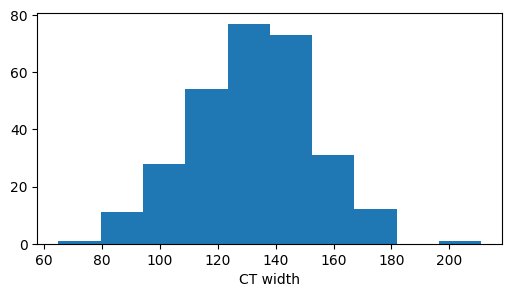

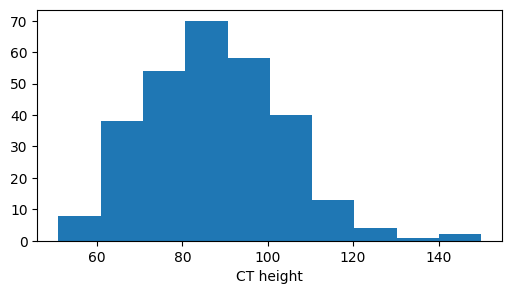

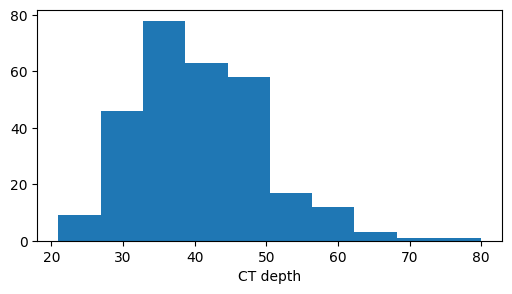

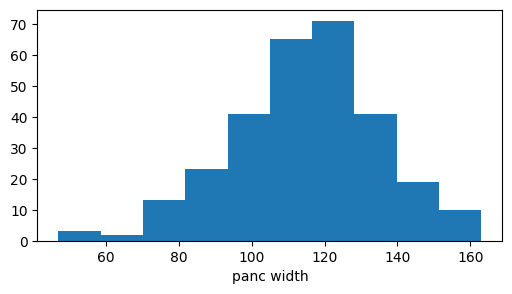

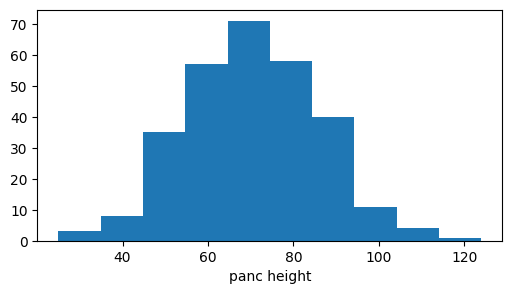

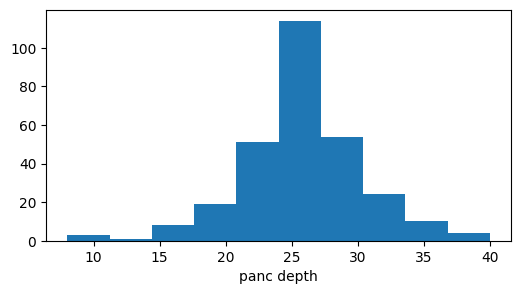

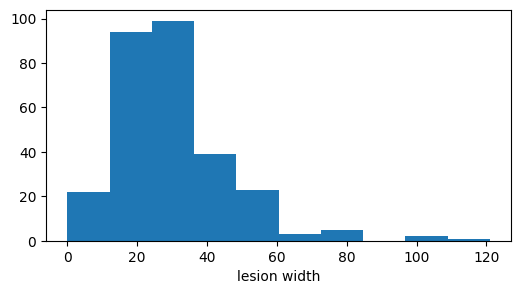

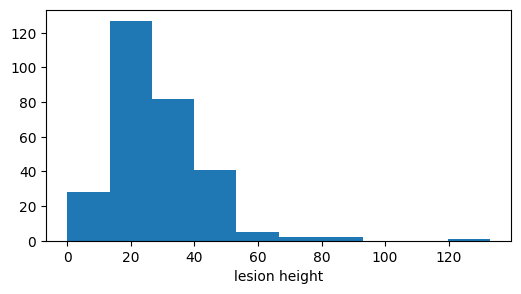

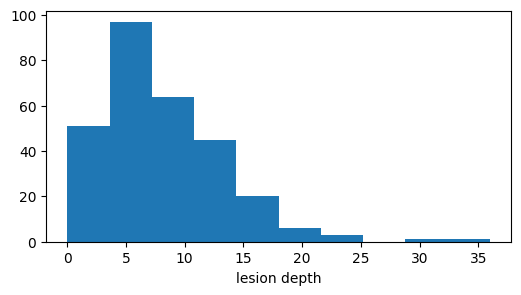

In [21]:

## generate histograms of metadata

for i, column in enumerate(trainval_df):
    if (i > 2 and i <= 11):
        plt.figure(i, figsize=(6, 3))
        plt.hist(trainval_df[column])
        plt.xlabel(column)


In [ ]:
# testing bounding box function, and testing has_pancreas and has_lesion

def bbox_2D(img):
    """Finds the bounding box around a 2D image (numpy)
    returns rmin, rmax, cmin, cmax (r = row, c = column)"""
    try:
        c = np.any(img, axis=0)    #y , (c = column)
        r = np.any(img, axis=1)    #x , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
    
        return rmin, rmax, cmin, cmax
    except:
        return -1, -1, -1, -1

def get_patches(image_npy, mask_npy, patch_width, patch_height, topleft_row = 0, topleft_col = 0, 
                has_pancreas = False, has_lesion = False, random = True):
    """ 
    Returns patches of the 'image_npy' and segmentation 'mask_npy'
    with 'patch_width' (columns) and 'patch_height (rows)
    
    Can specify the top left corner: 'topleft_row' and 'topleft_col'
    
    Can specify if patch has to contain pancreas/lesion or not
    
    Can also return a random patch within the image/segmentation
    """
    
    image_height, image_width = np.shape(image_npy)
    
    assert(patch_width < np.shape(image_npy)[1] and patch_height < np.shape(image_npy)[0])   ## CT image is z (slice index), y (row index), x (column index)
    
    if random:   # random patch, within constraints    
    # if it must contain the pancreas and lesion:
    # then you can only go up to panc min - patch size, and panc max + patch size
    # top left is going to be max(0, (panc min - patch size)) to min(image width, panc max + patch size)
    
        if has_lesion:
            rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 2)
        
            if rmin == -1 and has_pancreas:
                rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 1)
            
        elif has_pancreas:
            rmin, rmax, cmin, cmax = bbox_2D(mask_npy == 1)
            
        else:
            rmin, rmax, cmin, cmax = (-1, -1, -1, -1)
            
        
        if rmin != -1:
            patch_rmin = max(0, rmin - patch_height)
            patch_rmax = min(image_height - patch_height, rmax)
            patch_cmin = max(0, cmin - patch_width)
            patch_cmax = min(image_width - patch_width, cmax)
            
        else:    # gets a random patch, as there is no pancreas or lesion
            patch_rmin = 0
            patch_rmax = image_height - patch_height
            patch_cmin = 0
            patch_cmax = image_width - patch_width
    
        topleft_row = np.random.randint(patch_rmin, patch_rmax)
        topleft_col = np.random.randint(patch_cmin, patch_cmax)
        
    
    image_patch = image_npy[topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    mask_patch = mask_npy[topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    
    return image_patch, mask_patch, topleft_row, topleft_col



    
imagepath = '/kaggle/input/pancreas/train/subtype0/quiz_0_070_0000.nii/PANORAMA_101238_00001_0000.nii'
maskpath = '/kaggle/input/pancreas/train/subtype0/quiz_0_070.nii/PANORAMA_101238_00001.nii'

image_npy, mask_npy = getNumpysFromImageAndMask(imagepath, maskpath)

print(np.shape(image_npy))

# if the slice has pancreas, or has lesion
has_pancreas = np.sum(np.reshape(mask_npy, (np.shape(mask_npy)[0], -1)) == 1, axis=1) > 0
has_lesion = np.sum(np.reshape(mask_npy, (np.shape(mask_npy)[0], -1)) == 2, axis=1) > 0

slicenum = 71

img_slice = image_npy[slicenum, :, :]
mask_slice = mask_npy[slicenum, :, :]


plt.figure()
plt.imshow(img_slice, cmap='gray')

plt.figure()
plt.imshow(mask_slice)

image_patch, mask_patch, topleft_row, topleft_col = get_patches(img_slice, mask_slice, 64, 64, has_pancreas=True, has_lesion=True, random=True)

plt.figure()
plt.imshow(image_patch, cmap='gray')

plt.figure()
plt.imshow(mask_patch)




In [ ]:
##############################
##############################
### OLD CODE BELOW
##############################
##############################

In [ ]:
##############################
##############################
### OLD CODE BELOW
##############################
##############################

In [ ]:
"""

##############################
##############################
### OLD CODE BELOW
##############################
##############################

### Loading images

train0dir = '/kaggle/input/pancreas/train/subtype0'
train1dir = '/kaggle/input/pancreas/train/subtype1'
train2dir = '/kaggle/input/pancreas/train/subtype2'


train0images = [os.path.join(train0dir, file_name) for file_name in os.listdir(train0dir) if '0000' in file_name]
train1images = [os.path.join(train1dir, file_name) for file_name in os.listdir(train1dir) if '0000' in file_name]
train2images = [os.path.join(train2dir, file_name) for file_name in os.listdir(train2dir) if '0000' in file_name]

train0images.sort()
train1images.sort()
train2images.sort()

train0masks = [file_name.partition("_0000")[0] + '.nii' for file_name in train0images]
train1masks = [file_name.partition("_0000")[0] + '.nii' for file_name in train1images]
train2masks = [file_name.partition("_0000")[0] + '.nii' for file_name in train2images]

#print(train0images)
#print(train0masks)

train0imageniftis = [os.path.join(trainimage, os.listdir(trainimage)[0]) for trainimage in train0images]
train1imageniftis = [os.path.join(trainimage, os.listdir(trainimage)[0]) for trainimage in train1images]
train2imageniftis = [os.path.join(trainimage, os.listdir(trainimage)[0]) for trainimage in train2images]

train0maskniftis = [os.path.join(trainmask, os.listdir(trainmask)[0]) for trainmask in train0masks]
train1maskniftis = [os.path.join(trainmask, os.listdir(trainmask)[0]) for trainmask in train1masks]
train2maskniftis = [os.path.join(trainmask, os.listdir(trainmask)[0]) for trainmask in train2masks]

#print(train1imageniftis)


# sample image

# the segmentations do not exactly overlay with the images
# will need to resample using NN interpolation


testimage = train0imageniftis[1]
testmask = train0maskniftis[1]

print(testimage)
print(testmask)

#img = nib.load(testpath)
img = sitk.ReadImage(testpath)
mask = sitk.ReadImage(testmask)

img_vol = sitk.GetArrayFromImage(img)
mask_vol = sitk.GetArrayFromImage(mask)


'''# Create a new .csv file that can be reference by the data loader
# It will aggregate all of the slices together, and then index them


master_slicedf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                               'slice': pd.Series(dtype = 'int')  })
for index, row in traindf.iterrows():
#if 1 == 1:
    #row = traindf.iloc[0]
    
    filename = row['train/val']
    ID = row['ID']
    num_slices = row['CT height']
    
    # ID, slice
    slice_array = np.arange(0, num_slices, 1)
    
    slicedf = pd.DataFrame({'slice': slice_array})
    slicedf['ID'] = ID
    
    master_slicedf = pd.concat([master_slicedf, slicedf])

master_slicedf.index = np.arange(0, len(master_slicedf.index), 1)
#print(len(master_slicedf.index))
#print(master_slicedf)
master_slicedf.to_csv('master_slice.csv')



## THIS DOESNT WORK
plt.figure(j % 3)
        if j % 3 == 0:
            fig, axes = plt.subplots(1, 3)
        
            axes[(j % 3)].hist(trainval_df[column])
            axes[(j % 3)].set(xlabel = column)
        
            plt.xlabel(column)
            j = j + 1
        